In [1]:
# python Explainer_Experiments.py --model_name CMPNN \
#                                                        --attribution_name GradInput \
#                                                        --data_path ../MolRep/Datasets/Metabolism/admet2.1_rlm_merge.csv \
#                                                        --dataset_name RLM \
#                                                        --smiles_col COMPOUND_SMILES \
#                                                        --target_col CLF_LABEL \
#                                                        --task_type Multi-Classification \
#                                                        --multiclass_num_classes 3 \
#                                                        --output_dir ../Outputs

from datetime import datetime
MODELPATH = None

In [2]:
OUTPUT_DIR = f'../Outputs/{datetime.now().strftime("%Y%m%d_%H%M%S")}'
DATASET = '3MR'
MODEL = 'CMPNN' # Options:  ['MPNN', 'DMPNN', 'CMPNN', 'GIN', 'ECC', 'GAT', 'DGCNN', 'DiffPool', 'GraphSAGE', 'GraphNet']
ATTRIBUTION = 'IG' # Options: IG CAM MCTS GradInput GradCAM RandomBaseline
DATAPATH = '../Datasets/XAI/3MR/toy_label_mw350.csv'
SMILESCOL = 'SMILES'
TARGETCOL = 'label_full'
ATTRIBUTIONPATH = '../Datasets/XAI/3MR/attributions.npz'
TASKTYPE = 'Classification' # Can be 'Multi-Classification', 'Classification', 'Regression'
MULTICLASS_NUM_CLASSES = 2 # Can be 3
TESTING = True
SPLITTYPE = 'defined' # Can be 'random', 'scaffold', or other defined for dataset
SPLITCOLUMN = 'splits'

# Set the model path, if a trained model exists.
MODELPATH = '../Models/CMPNN_3MR_explainer_20240519_143138.pt'

In [3]:
from MolRep.Utils.logger import Logger
from MolRep.Explainer.explainerExperiments import ExplainerExperiments
from MolRep.Explainer.explainerDataWrapper import ExplainerDatasetWrapper
from MolRep.Utils.config_from_dict import Grid, Config, DatasetConfig
import torch
from pathlib import Path
import MolRep
import os
from numba.cuda import args

LOGGER_BASE = os.path.join(OUTPUT_DIR, "Logger", f"{DATASET}_explainer")
logger = Logger(str(os.path.join(LOGGER_BASE, f"{MODEL}_{DATASET}_explainer_by_{ATTRIBUTION}.log")), mode='a')

data_dir = Path('../MolRep/Data')
split_dir = Path('../MolRep/Splits')
os.makedirs(data_dir, exist_ok=True)
os.makedirs(split_dir, exist_ok=True)
svg_dir = os.path.join(OUTPUT_DIR, f"{MODEL}_{DATASET}_explainer", "SVG", f"{ATTRIBUTION}")

output_dir = Path(OUTPUT_DIR)
if MODELPATH is None:
    MODELPATH = os.path.join(OUTPUT_DIR, f"{MODEL}_{DATASET}_explainer", f"{MODEL}.pt")
os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(svg_dir, exist_ok=True)

# torch.set_num_threads(1)



In [4]:

data_stats = {
            'name': DATASET,
            'path': DATAPATH,
            'smiles_column': SMILESCOL,
            'target_columns': [TARGETCOL],
            'attribution_path': ATTRIBUTIONPATH,
            'task_type': TASKTYPE,
            'multiclass_num_classes': MULTICLASS_NUM_CLASSES,
            'metric_type': 'rmse' if TASKTYPE == 'Regression' else ['acc', 'auc', 'f1', 'precision', 'recall'],
            'split_type': SPLITTYPE
}

if TESTING:
    data_stats['additional_info'] = {"splits":SPLITCOLUMN}



In [5]:
config_file = '../MolRep/Configs/config_{}.yml'.format(MODEL)
model_configurations = Grid(config_file)
model_configuration = Config(**model_configurations[0])
dataset_configuration = DatasetConfig(DATASET, data_dict=data_stats)

exp_path = os.path.join(output_dir, f'{model_configuration.exp_name}_{dataset_configuration.exp_name}_explainer')

dataset = ExplainerDatasetWrapper(dataset_config=dataset_configuration,
                                  model_name=model_configuration.exp_name,
                                  split_dir=split_dir, features_dir=data_dir)



In [6]:
explainer_experiment = ExplainerExperiments(model_configuration, dataset_configuration, exp_path)

if not os.path.exists(MODELPATH):
    explainer_experiment.run_valid(dataset, ATTRIBUTION, logger=logger, other={'model_path':MODELPATH})

Moving model to cuda


C:\Users\Tim\PycharmProjects\MolRep\.venv\lib\site-packages\torch\autograd\graph.py:744: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\cuda\CublasHandlePool.cpp:135.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


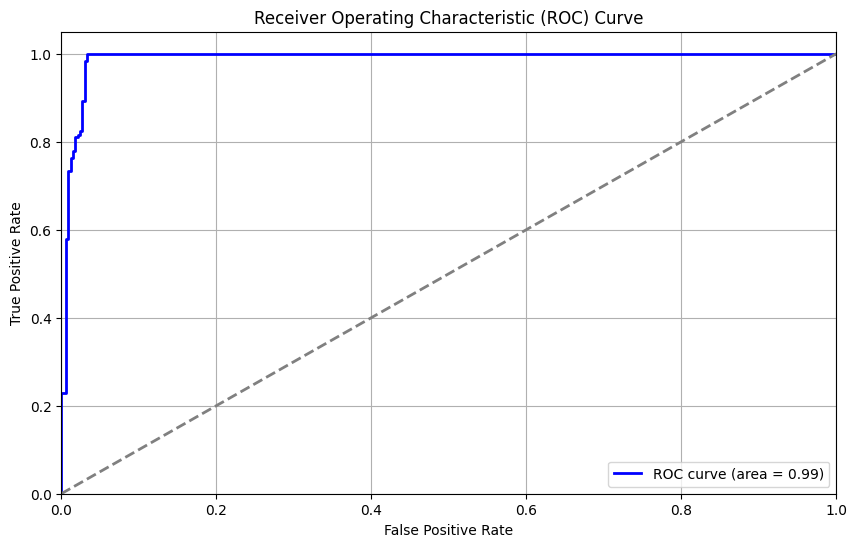

(576, 3)
..\Models\CMPNN_explained_by_IG_oof.csv


In [7]:
results, atom_importance, bond_importance = explainer_experiment.molecule_importance(dataset=dataset, attribution=ATTRIBUTION, logger=logger, other={'model_path':MODELPATH}, testing=TESTING)

In [11]:
from Examples.Helpers.Dataset_Splitting import filter_smiles_idxs, contains_benzene, contains_halogen

FILTER = 'Benzene' #'Benzene' 'Halogens'

contain_indices, not_contain_indices = filter_smiles_idxs(dataset.get_smiles_list(), contains_benzene)

binary = ATTRIBUTION == 'MCTS'


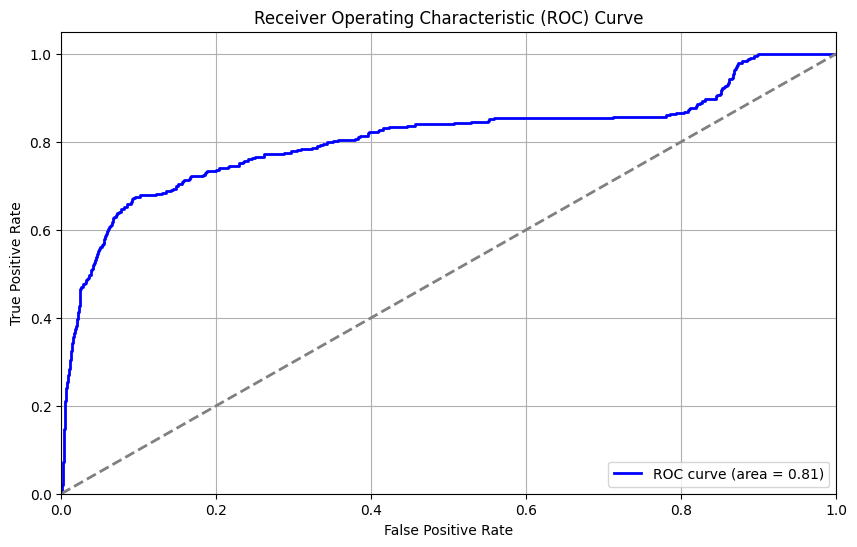

attribution_results contain:OrderedDict([('Attribution AUROC', 0.7384023984877255), ('Attribution F1', 0.11802168021680216), ('Attribution ACC', 0.9572056861965668), ('Attribution Precision', 0.21951219512195122), ('Attribution AUROC Mean', 0.8092748775251177), ('Attribution ACC Mean', 0.9594157942354918)])
opt_threshold contain:0.02


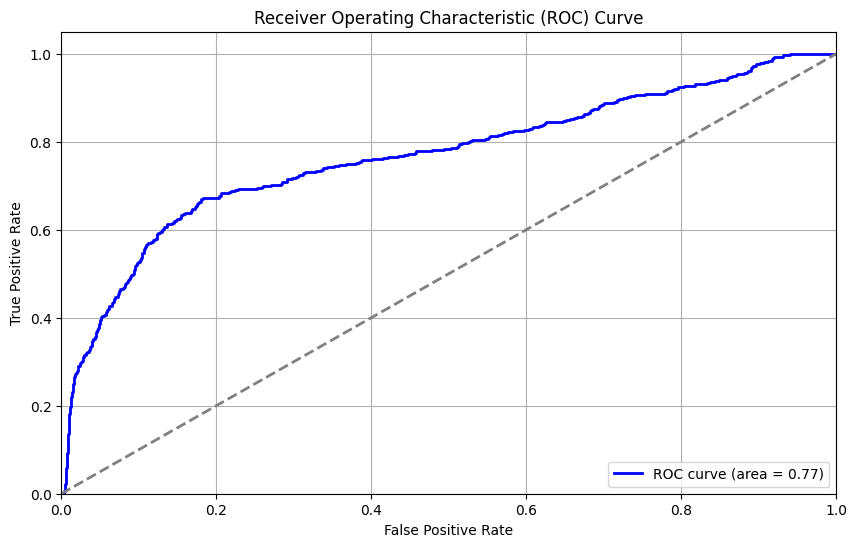

attribution_results not contain:OrderedDict([('Attribution AUROC', 0.7514490924697795), ('Attribution F1', 0.2698182654704394), ('Attribution ACC', 0.9020118836543307), ('Attribution Precision', 0.4814814814814815), ('Attribution AUROC Mean', 0.7685718054534834), ('Attribution ACC Mean', 0.901999506294742)])
opt_threshold not contain:0.01


In [12]:


attribution_results_contain, opt_threshold_contain = explainer_experiment.evaluate_attributions(dataset, atom_importance, bond_importance, binary=binary, indices=contain_indices)

logger.log('attribution_results contain:' + str(attribution_results_contain))
logger.log('opt_threshold contain:' + str(opt_threshold_contain))

attribution_results_not_contain, opt_threshold_not_contain = explainer_experiment.evaluate_attributions(dataset, atom_importance, bond_importance, binary=binary, indices=not_contain_indices)

logger.log('attribution_results not contain:' + str(attribution_results_not_contain))
logger.log('opt_threshold not contain:' + str(opt_threshold_not_contain))


Test results: {'acc': 0.9809027777777778, 'auc': 0.9898775429587202, 'f1': 0.9779559118236473, 'precision': 0.9568627450980393, 'recall': 1.0}


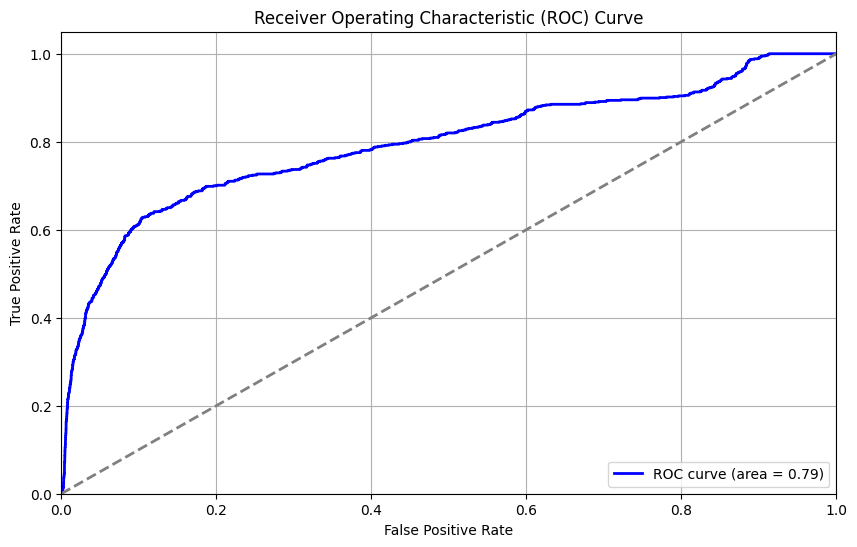

attribution_results:OrderedDict([('Attribution AUROC', 0.7454069759944839), ('Attribution F1', 0.14743303571428573), ('Attribution ACC', 0.9372137997978436), ('Attribution Precision', 0.2899305555555556), ('Attribution AUROC Mean', 0.7945229818328253), ('Attribution ACC Mean', 0.9397692568713947)])
opt_threshold:0.02


NameError: name 'pd' is not defined

In [10]:

import pandas as pd

logger.log('Test results: %s' % str(results))

# print(attribution_results)

if DATASET in ['hERG', 'CYP3A4']:
    attribution_results, opt_threshold = explainer_experiment.evaluate_cliffs(dataset, atom_importance, bond_importance)
else:
    binary = True if ATTRIBUTION == 'MCTS' else False
    #TODO not working, because ATTRIBUTIONPATH is not set and attributions are not saved
    attribution_results, opt_threshold = explainer_experiment.evaluate_attributions(dataset, atom_importance, bond_importance, binary=binary)

#TODO not working
logger.log('attribution_results:' + str(attribution_results))
logger.log('opt_threshold:' + str(opt_threshold))

explainer_experiment.visualization(dataset, atom_importance, bond_importance, svg_dir=svg_dir, testing=TESTING)

df = pd.DataFrame(
    {'SMILES': dataset.get_smiles_list(), 'Atom_importance': atom_importance, 'Bond_importance':bond_importance}
)
df.to_csv(os.path.join(svg_dir, "importances.csv"), index=False)